# Age Estimation using the YOLO algorithm

Authors: Isak Killingrød, Jon A B Larssen, Jon I J Skånøy

## Setup

#### **Conda**
```bash
	conda create -n yoloenv python=3.10 ipykernel -y
	conda activate yoloenv
```

#### **virtualenv**
```bash
	python -m venv yoloenv
	source yoloenv/bin/activate  # or .\yoloenv\Scripts\activate on Windows
	pip install --upgrade pip
	pip install ipykernel
```

#### **Ubuntu**
`python -m ipykernel install --user --name yoloenv --display-name "Python (yoloenv)"`

(Maybe wait a bit. The kernel command is sometimes slow on UiA server)

Then launch Jupyter and switch to the environment's kernel if needed.

#### Note

It has been a bit struggle with cross-platform package conflicts and it still output some warnings, but they should disappear on notebook restart


---------


### Installations

In [1]:
import os, sys, json, time, re, glob, random, warnings, tarfile, shutil
from pathlib import Path
from datetime import datetime
import platform, subprocess

In [2]:
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ipywidgets", "requests", "tqdm", "optuna", "gdown"])

0

In [3]:
if platform.system() == "Windows":
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "torch==2.2.2+cu118", "torchvision==0.17.2+cu118", "--index-url", "https://download.pytorch.org/whl/cu118"])
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pywin32"])
    print("Running on Windows")
    STORAGE = 'YOLO' #'YOLO_NB_LOCAL'
    MODEL_SIZES = ['n', 's', 'm', 'l','x']
    MODEL_VERSIONS = [8,9,10,11,12]
    IMAGE_SIZE = 416
elif platform.system() == "Linux":
    print("Running on Linux")
    STORAGE = 'YOLO' #'YOLO_NB_SERVER'
    MODEL_SIZES = ['x', 'l', 'm', 's', 'n']
    MODEL_VERSIONS = [12,11,10,9,8]
    IMAGE_SIZE = 416
else:
    print(f"Running on {platform.system()}")
    STORAGE = 'YOLO' #'YOLO_NB_UNKNOWN'

Running on Windows


In [4]:
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ultralytics", "facenet-pytorch"])

0

### Imports

In [5]:
%matplotlib inline
from tqdm.notebook import tqdm

In [6]:
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import cv2
import yaml
import optuna
from optuna.trial import TrialState
from ultralytics import YOLO
import gdown

import torch, torchvision
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN

In [7]:
print(f"✅ Torch version: {torch.__version__}")
print(f"✅ TorchVision version: {torchvision.__version__}")
print(f"🧠 CUDA available : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 CUDA device     : {torch.cuda.get_device_name(0)}")
    print(f"🔢 CUDA capability : {torch.cuda.get_device_capability(0)}")
    print(f"🧮 CUDA version    : {torch.version.cuda}")
else:
    print("⚠️ CUDA is NOT available in this environment.")

✅ Torch version: 2.2.2+cu118
✅ TorchVision version: 0.17.2+cu118
🧠 CUDA available : True
🚀 CUDA device     : NVIDIA GeForce RTX 3080
🔢 CUDA capability : (8, 6)
🧮 CUDA version    : 11.8


### Config

In [8]:
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
SPEEDRUN = False         # Only True if testing notebook functionality
USE_MAX_BATCH = False    # Only True if testing notebook functionality

In [10]:
DOWNLOAD_OPTUNA_DB = True
RUN_OPTUNA = False
RUN_EXP_MODEL_SIZES = True
RUN_EXP_DATA_AUGMENTATION = True
RUN_EXP_MODEL_VERSIONS = True

In [11]:
NUM_WORKERS = os.cpu_count() // 2 # For preprocessing, not tuning or training

In [12]:
USERNAME = 'adiencedb'
PASSWORD = 'adience'

In [13]:
DATA_DIR = 'data'
BASE_URL = 'http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/'
ARCHIVE_URL = BASE_URL + "faces.tar.gz"
ARCHIVE_PATH = os.path.join(DATA_DIR, "faces.tar.gz")

In [14]:
os.makedirs(DATA_DIR, exist_ok=True)

### Functions

#### Utils

In [15]:
def show_random_samples_with_bbox(image_dir, label_dir, creator, n=3):
    """
    Displays a set of random images from the specified directory, optionally with bounding boxes
    and age category annotations, for visualization and sanity checks of the dataset.

    Parameters:
        image_dir (str): Path to the directory containing image files.
        label_dir (str): Path to the directory containing corresponding YOLO label files.
        creator (FaceAgeDatasetCreator): Object that provides age category mapping.
        n (int): Number of random samples to display. Defaults to 4.

    Raises:
        ValueError: If the number of available images is less than n.
    """
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in image_extensions]

    if len(image_files) < n:
        raise ValueError(f"Not enough images in {image_dir} to display {n} samples.")

    selected_images = random.sample(image_files, n)
    plt.figure(figsize=(5 * n, 5))

    for idx, img_file in enumerate(selected_images):
        img_path = os.path.join(image_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)

        if not os.path.exists(label_path):
            print(f"Warning: Label not found for {img_file}, skipping.")
            continue

        # Load image
        img = Image.open(img_path)
        img_w, img_h = img.size

        # Load label
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            class_id = int(line[0])
            x_center, y_center, width, height = map(float, line[1:5])

        # Convert YOLO to pixel coordinates
        x1 = int((x_center - width / 2) * img_w)
        y1 = int((y_center - height / 2) * img_h)
        x2 = int((x_center + width / 2) * img_w)
        y2 = int((y_center + height / 2) * img_h)

        # Plot
        plt.subplot(1, n, idx + 1)
        plt.imshow(img)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', fill=False, linewidth=2))
        age_category = creator.age_categories[class_id]
        plt.title(f"{age_category[0]}–{age_category[1]} yrs")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [16]:
def get_model_filename(version, size):
    """
    Returns the appropriate model filename based on YOLO version and model size.

    Parameters:
        version (str or int): YOLO model version (e.g., 8, 9, 10).
        size (str): Model size identifier ('n', 's', 'm', 'l', 'x').

    Returns:
        str: Corresponding filename of the YOLO model.

    Raises:
        KeyError: If the size is not mapped in the version-specific dictionary.
    """
    version = str(version).lower()
    size = size.lower()

    if version == '9':
        model_map = {
            'n': 'yolov9t.pt',
            's': 'yolov9s.pt',
            'm': 'yolov9m.pt',
            'l': 'yolov9c.pt',
            'x': 'yolov9e.pt',
        }
        return model_map[size]

    if version in ['8', '10']:
        return f'yolov{version}{size}.pt'
    elif version in ['11', '12']:
        return f'yolo{version}{size}.pt'

#### Tuning

In [17]:
def make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial):
    """
    Creates and returns an objective function for Optuna hyperparameter tuning for YOLO training.

    Parameters:
        model_path (str): Path to the YOLO model file.
        data_yaml (str): Path to the dataset YAML file.
        imgsz (int): Image resolution for training.
        device (str): Computation device (e.g., 'cpu' or 'cuda').
        epochs_per_trial (int): Number of training epochs per Optuna trial.

    Returns:
        Callable: An objective function compatible with Optuna's study.optimize().
    """
    def objective(trial):
        params = {
            'lr0': trial.suggest_float('lr0', 1e-5, 1e-1, log=True),
            'lrf': trial.suggest_float('lrf', 0.01, 1.0),
            'momentum': trial.suggest_float('momentum', 0.6, 0.98),
            'weight_decay': trial.suggest_float('weight_decay', 0.0001, 0.001, log=True),
            'warmup_epochs': trial.suggest_int('warmup_epochs', 1, 5),
            'warmup_momentum': trial.suggest_float('warmup_momentum', 0.5, 0.95),
            'box': trial.suggest_float('box', 0.02, 0.2),
            'cls': trial.suggest_float('cls', 0.2, 4.0),
            'hsv_h': trial.suggest_float('hsv_h', 0.0, 0.1),
            'hsv_s': trial.suggest_float('hsv_s', 0.5, 0.9),
            'hsv_v': trial.suggest_float('hsv_v', 0.5, 0.9),
            'degrees': trial.suggest_float('degrees', 0.0, 45.0),
            'translate': trial.suggest_float('translate', 0.0, 0.5),
            'scale': trial.suggest_float('scale', 0.0, 0.5),
            'fliplr': trial.suggest_float('fliplr', 0.0, 0.5),
            'mosaic': trial.suggest_float('mosaic', 0.0, 1.0),
            'batch': trial.suggest_int('batch', 32, 32) if not SPEEDRUN else 0.9,  # TEMPDEV
            'imgsz': trial.suggest_int('imgsz', imgsz, imgsz),
            'optimizer': 'AdamW',
            'fraction': 1.0 if not SPEEDRUN else 0.1 # TEMPDEV
            
        }

        try:
            model = YOLO(model_path)
            results = model.train(
                data=data_yaml,
                cache='disk',
                workers=1,
                epochs=epochs_per_trial,
                device=device,
                verbose=False,
                plots=True if not SPEEDRUN else False,
                **params
            )
            return float(results.fitness) if hasattr(results, 'fitness') else 0.0
        except Exception as e:
            print(f"❌ Trial failed with error: {e}")
            return 0.0
    return objective

In [18]:
def run_optuna_tuning(
    data_yaml,
    model_size='n',
    output_dir='runs/tune_optuna',
    imgsz=416,
    n_trials=40,
    epochs_per_trial=30,
    model_version=8,
    device='0'):
    """
    Runs or resumes an Optuna study to tune YOLO hyperparameters using a given dataset and model configuration.

    Parameters:
        data_yaml (str): Path to dataset YAML file.
        model_size (str): YOLO model size ('n', 's', etc.).
        output_dir (str): Directory to store tuning outputs.
        imgsz (int): Image resolution.
        n_trials (int): Number of Optuna trials.
        epochs_per_trial (int): Number of epochs per trial.
        model_version (int): YOLO model version.
        device (str): Computation device identifier.

    Returns:
        Tuple[dict, float]: Best hyperparameters found and corresponding performance value.
    """

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_name = f"optuna_v{model_version}_{model_size}_{timestamp}"
    output_path = os.path.join(output_dir, run_name)
    os.makedirs(output_path, exist_ok=True)

    try:
        model_path = get_model_filename(model_version, model_size)
    except ValueError as e:
        print(f"❌ Invalid model request: {e}")
        return {}, 0.0

    study_name = f"yolo_v{model_version}{model_size}"
    study_storage = f"sqlite:///{STORAGE}.db"

    try:
        summaries = optuna.study.get_all_study_summaries(storage=study_storage)
    except Exception as e:
        print(f"❌ Failed to load Optuna study summaries: {e}")
        return {}, 0.0

    existing_study = next((s for s in summaries if s.study_name == study_name), None)
    existing_trials = existing_study.n_trials if existing_study else 0

    if existing_trials >= n_trials:
        print(f"⏩ Skipping tuning: {existing_trials} completed trials already (target was {n_trials}).")
        try:
            study = optuna.load_study(study_name=study_name, storage=study_storage)
            if len(study.trials) == 0 or study.best_trial is None:
                print("⚠️ Study exists but has no valid completed trials.")
                return {}, 0.0
            best_params = study.best_params
            best_value = study.best_value
        except ValueError as e:
            print(f"⚠️ Could not retrieve best trial: {e}")
            return {}, 0.0
    else:
        remaining_trials = n_trials - existing_trials
        print(f"🔄 Starting/resuming tuning: {remaining_trials} trials needed.")
        try:
            study = optuna.create_study(
                direction='maximize',
                study_name=study_name,
                storage=study_storage,
                load_if_exists=True
            )
            objective = make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial)
            study.optimize(objective, n_trials=remaining_trials)

            if len(study.trials) == 0 or study.best_trial is None:
                print("⚠️ Tuning completed but no valid trials found.")
                return {}, 0.0

            best_params = study.best_params
            best_value = study.best_value
        except Exception as e:
            print(f"❌ Failed during tuning process: {e}")
            return {}, 0.0

    with open(os.path.join(output_path, f'best_params_v{model_version}_{model_size}.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

    print(f"\n✅ Best result for YOLOv{model_version}-{model_size}: {best_value:.4f}")
    return best_params, best_value

In [19]:
def run_optuna_tuning_multi(
    base_dataset_dir='data/age_dataset_tune',
    model_sizes=['n', 's', 'm', 'l', 'x'],
    model_versions=[8, 9, 10, 11, 12],
    imgsz=416,
    n_trials=10,
    epochs_per_trial=30,
    device='0',
    output_base='runs/age_exp'
):
    """
    Runs Optuna hyperparameter tuning for multiple combinations of YOLO model sizes and versions
    over a given dataset.

    Parameters:
        base_dataset_dir (str): Path to the base dataset directory.
        model_sizes (list): List of model size identifiers.
        model_versions (list): List of YOLO model versions.
        imgsz (int): Image resolution.
        n_trials (int): Number of Optuna trials per configuration.
        epochs_per_trial (int): Epochs per trial.
        device (str): Device for training (e.g., '0' for GPU).
        output_base (str): Base path to save output from all tuning runs.
    """

    data_yaml = os.path.join(base_dataset_dir, "data.yaml")

    if not data_yaml:
        print(f"⚠️ No datasets found in: {base_dataset_dir}")
        return

    print(f"\n📂 Evaluating dataset: {data_yaml}")

    for version in model_versions:
        for size in model_sizes:
            try:
                model_filename = get_model_filename(version, size)
            except ValueError as e:
                print(f"⏭️ Skipping unsupported model: YOLOv{version}-{size} ({e})")
                continue

            dataset_name = Path(data_yaml).parent.name
            run_name = f"v{version}_{size}"
            output_dir = os.path.join(output_base, run_name)

            print(f"\n{'='*100}")
            print(f"🧪 Tuning: YOLOv{version}-{size} on dataset {dataset_name}")
            print(f"{'='*100}")

            best_params, best_value = run_optuna_tuning(
                data_yaml=data_yaml,
                model_size=size,
                model_version=version,
                output_dir=output_dir,
                imgsz=imgsz,
                n_trials=n_trials,
                epochs_per_trial=epochs_per_trial,
                device=device
            )

In [20]:
def merge_optuna_databases(source_db_paths, target_db_path):
    """
    Merges completed Optuna trials from multiple source databases into a single target database.

    Parameters:
        source_db_paths (list): List of Optuna database paths to merge from.
        target_db_path (str): Target database path to merge into.
    """
    target_storage = optuna.storages.RDBStorage(url=target_db_path)

    for db_path in source_db_paths:
        source_storage = optuna.storages.RDBStorage(url=db_path)
        study_summaries = optuna.get_all_study_summaries(storage=source_storage)
        
        for summary in study_summaries:
            study = optuna.load_study(study_name=summary.study_name, storage=source_storage)
            
            try:
                new_study = optuna.create_study(
                    study_name=study.study_name,
                    storage=target_storage,
                    direction=study.direction
                )
            except optuna.exceptions.DuplicatedStudyError:
                new_study = optuna.load_study(
                    study_name=study.study_name,
                    storage=target_storage
                )
            
            for trial in study.get_trials(deepcopy=True, states=(TrialState.COMPLETE,)):
                new_study.add_trial(trial)

In [21]:
def extract_study_trials_to_dataframe(db_paths, filter_study_name=None, sort_by_value=True):
    """
    Extracts trial data from one or more Optuna databases into a Pandas DataFrame for analysis.

    Parameters:
        db_paths (list): Paths to Optuna study databases.
        filter_study_name (str): Optional study name to filter.
        sort_by_value (bool): Whether to sort trials by their value.

    Returns:
        pd.DataFrame: DataFrame containing trial results and parameters.
    """
    study_infos = []

    for db_path in db_paths:
        storage = optuna.storages.RDBStorage(url=db_path)
        summaries = optuna.get_all_study_summaries(storage=storage)

        for summary in summaries:
            if filter_study_name and summary.study_name != filter_study_name:
                continue
            
            study = optuna.load_study(study_name=summary.study_name, storage=storage)
            completed_trials = [t for t in study.get_trials(deepcopy=False) if t.state == TrialState.COMPLETE]
            completed_trials.sort(key=lambda x: x.value)
            
            for rank, trial in enumerate(completed_trials, 1):
                study_infos.append({
                    "Database": db_path,
                    "Study Name": summary.study_name,
                    "Rank": rank,
                    "Trial Number": trial.number,
                    "Value": trial.value,
                    **trial.params
                })

    df = pd.DataFrame(study_infos)
    
    if sort_by_value:
        df = df.sort_values(by=["Value"], ascending=False)

    return df

#### Training

In [22]:
def get_best_params(study_path=None, study_name=None, db_path=None):
    """
    Retrieves the best hyperparameters and score from a saved Optuna study.

    Parameters:
        study_path (str): Path to Optuna study file.
        study_name (str): Name of the Optuna study.
        db_path (str): Path to the study database.

    Returns:
        Tuple[dict, float]: Best parameters and best score from the study.
    """
    if study_path and os.path.exists(study_path):
        print(f"Loading Optuna study from file: {study_path}")
        study = optuna.load_study(study_name="loaded_study", storage=study_path)
    elif db_path and study_name:
        print(f"Loading Optuna study from database: {db_path}, study name: {study_name}")
        study = optuna.load_study(study_name=study_name, storage=db_path)
    else:
        raise ValueError("Either study_path or (db_path and study_name) must be provided")
    
    return study.best_params, study.best_value

In [23]:
def train_model(data_yaml, model_size, model_v, training_params, run_id, epochs=100, device='0', project='runs/multi_runs', base_name=None):
    """
    Trains a YOLO model using provided training parameters and dataset configuration.

    Parameters:
        data_yaml (str): Path to dataset YAML.
        model_size (str): YOLO model size.
        model_v (int): YOLO version.
        training_params (dict): Dictionary of training hyperparameters.
        run_id (int): Identifier for this training run.
        epochs (int): Number of training epochs.
        device (str): Device identifier.
        project (str): Path to save training results.
        base_name (str): Optional name prefix for this run.

    Returns:
        Tuple[YOLO.Results, str, float]: Training result object, run directory path, and total training time in seconds.
    """
    start_time = time.time()
    random_seed = random.randint(0, 10000)  
    print(f"Run {run_id}: Using random seed {random_seed}")
    
    # Set seeds
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True if not SPEEDRUN else False # TEMPDEV
    
    if base_name is None:
        base_name = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    name = f"{base_name}_run{run_id}"

    model_path = get_model_filename(model_v, model_size)
    print(f"Run {run_id}: Using model {model_path}")
    model = YOLO(model_path)
    
    training_params['seed'] = random_seed

    # Train with the best parameters
    print(f"\nRun {run_id}: Starting training for {epochs} epochs...")
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        cache='disk',
        device=device,
        project=project,
        name=name,
        verbose=False,
        **training_params
    )
    
    training_time = time.time() - start_time
    run_dir = os.path.join(project, name)
    print(f"Run {run_id}: Training completed in {training_time / 3600:.2f} hours. Results saved to {run_dir}")
    
    # Save the training time to a file
    with open(os.path.join(run_dir, 'training_time.txt'), 'w') as f:
        f.write(f"Training Time: {training_time:.2f} seconds ({training_time / 3600:.2f} hours)\n")
        f.write(f"Run ID: {run_id}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    return results, run_dir, training_time

In [24]:
def get_label_path(img_path):
    """
    Resolves the path to the label file corresponding to a given image path.

    Parameters:
        img_path (str or Path): Path to the image file.

    Returns:
        str: Path to the label file (with .txt extension).
    """
    img_path = Path(img_path)
    
    # Standard YOLO structure: 'images/train' -> 'labels/train'
    if 'images' in img_path.parts:
        idx = img_path.parts.index('images')
        label_path = Path(*img_path.parts[:idx], 'labels', *img_path.parts[idx+1:])
        label_path = label_path.with_suffix('.txt')
        if label_path.exists():
            return str(label_path)
    
    # Replace image extension with .txt in the same directory
    label_path = img_path.with_suffix('.txt')
    if label_path.exists():
        return str(label_path)
    
    # Check for a 'labels' directory at the same level as the image directory
    parent_dir = img_path.parent
    label_dir = parent_dir.parent / 'labels' / parent_dir.name
    label_path = label_dir / img_path.name
    label_path = label_path.with_suffix('.txt')
    if label_path.exists():
        return str(label_path)
    
    # Replace extension
    return str(img_path.with_suffix('.txt'))

In [25]:
def calculate_accuracy(model, data_yaml, conf_threshold=0.1):
    """
    Evaluates model accuracy on a validation set based on predicted and ground truth labels.

    Parameters:
        model (YOLO): Trained YOLO model for inference.
        data_yaml (str): Path to the dataset configuration YAML file.
        conf_threshold (float): Confidence threshold for predictions. Defaults to 0.1.

    Returns:
        Tuple[float, dict]: Overall accuracy and a dictionary with detailed evaluation results.
    """
    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Get the class names
    class_names = data_config['names']
    
    # Get validation dataset path
    val_path = data_config.get('val')
    if not val_path:
        raise ValueError("Validation set path not found in data.yaml")
    
    # If val_path is relative, make it absolute based on the data.yaml location
    data_dir = os.path.dirname(os.path.abspath(data_yaml))
    if not os.path.isabs(val_path):
        val_path = os.path.join(data_dir, val_path)
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []
    
    # Handle if val_path is a file with paths
    if os.path.isfile(val_path) and val_path.endswith('.txt'):
        with open(val_path, 'r') as f:
            for line in f:
                img_path = line.strip()
                # Convert relative paths to absolute if needed
                if not os.path.isabs(img_path):
                    img_path = os.path.join(data_dir, img_path)
                if os.path.exists(img_path):
                    image_files.append(img_path)
    # Handle if val_path is a directory
    elif os.path.isdir(val_path):
        for root, _, files in os.walk(val_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    image_files.append(os.path.join(root, file))
    else:
        raise ValueError(f"Invalid validation path: {val_path}")
    
    if not image_files:
        raise ValueError(f"No images found in validation set path: {val_path}")
    
    print(f"Found {len(image_files)} images in the validation set")
    
    # Initialize counters
    correct_predictions = 0
    total_images = 0
    one_off_correct_predictions = 0
    
    results_dict = {
        "per_image": [],
        "per_class": {class_id: {"correct": 0, "total": 0} for class_id in class_names}
    }
    
    # Process each image
    for img_path in tqdm(image_files, desc="Evaluating images"):
        # Get corresponding label file
        label_path = get_label_path(img_path)
        
        if not os.path.exists(label_path):
            print(f"Warning: No label file found for {img_path}")
            continue
        
        # Read ground truth labels
        ground_truth_classes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id x y w h
                    class_id = int(float(parts[0]))
                    ground_truth_classes.append(class_id)
        
        if not ground_truth_classes:
            print(f"Warning: No valid labels in {label_path}")
            continue
        
        # Run inference
        results = model(img_path, conf=conf_threshold, verbose=False)[0]
        
        # Get predictions
        predictions = results.boxes.data.cpu().numpy()
        
        # Sort predictions by confidence (descending)
        if len(predictions) > 0:
            # Sort by confidence (5th column, index 4)
            predictions = predictions[predictions[:, 4].argsort()[::-1]]
            
            # Get the most confident prediction
            most_confident_pred = predictions[0]
            pred_class_id = int(most_confident_pred[5])
            
            # Check if prediction matches any ground truth
            is_correct = pred_class_id in ground_truth_classes

            if is_correct:
                correct_predictions += 1

            one_off_correct = any(
                abs(pred_class_id - gt_class_id) <= 1
                for gt_class_id in ground_truth_classes
            )

            if one_off_correct:
                one_off_correct_predictions += 1
            
            # Update per-class statistics
            for gt_class in set(ground_truth_classes):  # Count each class only once per image
                results_dict["per_class"][gt_class]["total"] += 1
                if is_correct and pred_class_id == gt_class:
                    results_dict["per_class"][gt_class]["correct"] += 1
            
            # Store per-image results
            results_dict["per_image"].append({
                "image_path": img_path,
                "ground_truth": [class_names[cls] for cls in ground_truth_classes],
                "prediction": class_names[pred_class_id],
                "confidence": float(most_confident_pred[4]),
                "correct": is_correct,
                "one_off_correct": one_off_correct
            })
        else:
            # No detections
            results_dict["per_image"].append({
                "image_path": img_path,
                "ground_truth": [class_names[cls] for cls in ground_truth_classes],
                "prediction": "none",
                "confidence": 0.0,
                "correct": False,
                "one_off_correct": False
            })
            
            # Update per-class statistics (all are incorrect since no detection)
            for gt_class in set(ground_truth_classes):
                results_dict["per_class"][gt_class]["total"] += 1
        
        total_images += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_images if total_images > 0 else 0
    one_off_accuracy = one_off_correct_predictions / total_images if total_images > 0 else 0
    
    # Calculate per-class accuracy
    for class_id in results_dict["per_class"]:
        class_total = results_dict["per_class"][class_id]["total"]
        class_correct = results_dict["per_class"][class_id]["correct"]
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        results_dict["per_class"][class_id]["accuracy"] = class_accuracy
    
    results_dict["one_off_accuracy"] = one_off_accuracy
    results_dict["overall_accuracy"] = accuracy
    results_dict["total_images"] = total_images
    results_dict["correct_predictions"] = correct_predictions
    
    return accuracy, results_dict

In [26]:
def plot_confusion_matrix(cm, class_names, output_path, title='Confusion Matrix', normalize=False, figsize=(14, 12)):
    """
    Plots and saves a confusion matrix heatmap.

    Parameters:
        cm (np.ndarray): Confusion matrix to visualize.
        class_names (list): List of class labels.
        output_path (str): File path to save the plot.
        title (str): Plot title.
        normalize (bool): Whether to normalize matrix rows.
        figsize (tuple): Size of the plot figure.
    """
    plt.figure(figsize=figsize)
    
    # Use a different colormap for normalized vs raw
    cmap = 'Blues' if normalize else 'Blues'
    
    # Create heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.2f' if normalize else 'd', 
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        annot_kws={"size": 16}
    )
    
    # Set labels and title
    plt.ylabel('Ground Truth', fontsize=18)
    plt.xlabel('Prediction', fontsize=18)
    plt.title(title, fontsize=20)
    
    # Rotate tick labels if there are many classes
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14, rotation=0)
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    plt.close()

In [27]:
def generate_confusion_matrix(model, data_yaml, conf_threshold=0.1, output_dir=None):
    """
    Generates a confusion matrix comparing predicted vs actual class labels across the validation set.

    Parameters:
        model (YOLO): Trained YOLO model.
        data_yaml (str): Path to the dataset YAML.
        conf_threshold (float): Confidence threshold for filtering predictions.
        output_dir (str): Directory to save the confusion matrix and results.

    Returns:
        Tuple[np.ndarray, np.ndarray, dict]: Raw matrix, normalized matrix, and detailed results dictionary.
    """
    # Start timing
    start_time = time.time()
    
    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Get the class names and number of classes
    class_names = data_config['names']
    num_classes = len(class_names)
    
    # Get validation dataset path
    val_path = data_config.get('val')
    if not val_path:
        raise ValueError("Validation set path not found in data.yaml")
    
    # If val_path is relative, make it absolute based on the data.yaml location
    data_dir = os.path.dirname(os.path.abspath(data_yaml))
    if not os.path.isabs(val_path):
        val_path = os.path.join(data_dir, val_path)
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []
    
    # Handle if val_path is a file with paths
    if os.path.isfile(val_path) and val_path.endswith('.txt'):
        with open(val_path, 'r') as f:
            for line in f:
                img_path = line.strip()
                # Convert relative paths to absolute if needed
                if not os.path.isabs(img_path):
                    img_path = os.path.join(data_dir, img_path)
                if os.path.exists(img_path):
                    image_files.append(img_path)
    # Handle if val_path is a directory
    elif os.path.isdir(val_path):
        for root, _, files in os.walk(val_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    image_files.append(os.path.join(root, file))
    else:
        raise ValueError(f"Invalid validation path: {val_path}")
    
    if not image_files:
        raise ValueError(f"No images found in validation set path: {val_path}")
    
    print(f"Found {len(image_files)} images in the validation set")
    
    # Initialize confusion matrix (rows: ground truth, columns: predictions)
    # Add an extra class for "no detection"
    confusion_matrix = np.zeros((num_classes, num_classes + 1), dtype=int)
    
    # Results dictionary for detailed information
    results_dict = {
        "per_image": [],
        "confusion_matrix": None,
        "class_names": class_names,
    }
    
    # Process each image
    for img_path in tqdm(image_files, desc="Generating confusion matrix"):
        # Get corresponding label file
        label_path = get_label_path(img_path)
        
        if not os.path.exists(label_path):
            print(f"Warning: No label file found for {img_path}")
            continue
        
        # Read ground truth labels
        ground_truth_classes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id x y w h
                    class_id = int(float(parts[0]))
                    ground_truth_classes.append(class_id)
        
        if not ground_truth_classes:
            print(f"Warning: No valid labels in {label_path}")
            continue
        
        # Run inference
        results = model(img_path, conf=conf_threshold,verbose=False )[0]
        
        # Get predictions
        predictions = results.boxes.data.cpu().numpy()
        
        # For each ground truth class in the image
        for gt_class in ground_truth_classes:
            if gt_class >= num_classes:
                print(f"Warning: Ground truth class {gt_class} is out of range in {label_path}")
                continue
                
            # Check if there are any predictions
            if len(predictions) > 0:
                # Sort by confidence (descending)
                predictions = predictions[predictions[:, 4].argsort()[::-1]]
                
                # Get the most confident prediction
                most_confident_pred = predictions[0]
                pred_class_id = int(most_confident_pred[5])
                confidence = float(most_confident_pred[4])
                
                # Update confusion matrix
                confusion_matrix[gt_class, pred_class_id] += 1
                
                # Store per-image results
                results_dict["per_image"].append({
                    "image_path": img_path,
                    "ground_truth": gt_class,
                    "prediction": pred_class_id,
                    "confidence": confidence,
                    "correct": pred_class_id == gt_class
                })
            else:
                # No detection (represented by the last column)
                confusion_matrix[gt_class, -1] += 1
                
                # Store per-image results
                results_dict["per_image"].append({
                    "image_path": img_path,
                    "ground_truth": gt_class,
                    "prediction": "none",
                    "confidence": 0.0,
                    "correct": False
                })
    
    # Calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Store raw confusion matrix in results
    results_dict["confusion_matrix"] = confusion_matrix.tolist()
    results_dict["processing_time"] = processing_time
    
    # Calculate normalized confusion matrix (by row/ground truth)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    norm_confusion_matrix = np.zeros_like(confusion_matrix, dtype=float)
    for i in range(num_classes):
        if row_sums[i] > 0:
            norm_confusion_matrix[i] = confusion_matrix[i] / row_sums[i]
    
    # Save outputs if directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Convert class_names to a list if it's a dictionary
        if isinstance(class_names, dict):
            # If class_names is a dictionary, convert it to a list
            max_id = max(class_names.keys())
            class_names_list = [class_names.get(i, f"unknown_{i}") for i in range(max_id + 1)]
        else:
            # If class_names is already a list
            class_names_list = class_names
        
        # Create class labels for output
        class_labels = class_names_list.copy()
        header_labels = class_names_list + ['no_detection']
        
        # Save raw numbers to CSV
        raw_cm_path = os.path.join(output_dir, 'confusion_matrix_raw.csv')
        with open(raw_cm_path, 'w') as f:
            # Write header
            f.write(',' + ','.join(header_labels) + '\n')
            
            # Write each row
            for i, class_label in enumerate(class_labels):
                if i < confusion_matrix.shape[0]:  # Make sure we don't go out of bounds
                    row = [class_label] + [str(x) for x in confusion_matrix[i]]
                    f.write(','.join(row) + '\n')
        
        # Save normalized matrix to CSV
        norm_cm_path = os.path.join(output_dir, 'confusion_matrix_normalized.csv')
        with open(norm_cm_path, 'w') as f:
            # Write header
            f.write(',' + ','.join(header_labels) + '\n')
            
            # Write each row
            for i, class_label in enumerate(class_labels):
                if i < norm_confusion_matrix.shape[0]:  # Make sure we don't go out of bounds
                    row = [class_label] + [f"{x:.4f}" for x in norm_confusion_matrix[i]]
                    f.write(','.join(row) + '\n')
        
        # Save detailed results to JSON
        results_path = os.path.join(output_dir, 'confusion_matrix_results.json')
        with open(results_path, 'w') as f:
            json.dump(results_dict, f, indent=4)
        
        # Create and save visualizations
        plot_confusion_matrix(
            confusion_matrix, 
            header_labels,
            os.path.join(output_dir, 'confusion_matrix_raw.png'),
            title='Confusion Matrix (Raw Counts)',
            normalize=False
        )
        
        plot_confusion_matrix(
            norm_confusion_matrix, 
            header_labels,
            os.path.join(output_dir, 'confusion_matrix_normalized.png'),
            title='Confusion Matrix (Normalized by Row)',
            normalize=True
        )
        
        # Save processing time information
        time_path = os.path.join(output_dir, 'processing_time.txt')
        with open(time_path, 'w') as f:
            f.write(f"Confusion Matrix Generation Time: {processing_time:.2f} seconds\n")
            f.write(f"Images Processed: {len(image_files)}\n")
            f.write(f"Average Time Per Image: {processing_time/len(image_files):.4f} seconds\n")
            f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        print(f"Confusion matrix results saved to {output_dir}")
        print(f"Processing time: {processing_time:.2f} seconds")
    
    return confusion_matrix, norm_confusion_matrix, results_dict

In [28]:
def read_metrics_from_run(run_dir):
    """
    Reads YOLO training metrics from a results CSV file in a run directory.

    Parameters:
        run_dir (str): Path to the training run directory.

    Returns:
        dict: Dictionary of the final epoch's training metrics.
    """
    metrics_file = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(metrics_file):
        print(f"Warning: Metrics file not found at {metrics_file}")
        return {}
    
    # Read the CSV file and get the last row (final epoch metrics)
    try:
        df = pd.read_csv(metrics_file)
        final_metrics = df.iloc[-1].to_dict()
        return final_metrics
    except Exception as e:
        print(f"Error reading metrics file: {e}")
        return {}

In [29]:
def write_execution_time_log(filepath, overall_start_time, overall_end_time, num_runs, epochs):
    """
    Writes overall training execution time and metadata to a log file.

    Parameters:
        filepath (str): Path to the output log file.
        overall_start_time (float): UNIX timestamp of the start time.
        overall_end_time (float): UNIX timestamp of the end time.
        num_runs (int): Number of training runs.
        epochs (int): Number of epochs per run.
    """
    overall_time = overall_end_time - overall_start_time
    overall_hours = overall_time / 3600.0

    with open(filepath, 'w') as f:
        f.write(f"Overall Execution Time: {overall_time:.2f} seconds ({overall_hours:.2f} hours)\n")
        f.write(f"Start Time: {datetime.fromtimestamp(overall_start_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"End Time: {datetime.fromtimestamp(overall_end_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of Runs: {num_runs}\n")
        f.write(f"Epochs per Run: {epochs}\n")

In [30]:
def run_multiple_trainings(
    data_yaml: yaml,
    extra_train_params: dict,
    model_size: str = 'n',
    study_path=None,
    study_name=None,
    db_path=None,
    num_runs=5,
    model_v = "8",
    epochs=100,
    device='0',
    project='runs/multi_runs',
    conf_threshold=0.1):
    """
    Runs multiple training sessions with the best parameters from Optuna, logs metrics,
    evaluates accuracy, generates confusion matrices, and aggregates statistics.

    Parameters:
        data_yaml (str): Path to dataset YAML file.
        extra_train_params (dict): Additional training parameters to merge with best Optuna params.
        model_size (str): YOLO model size ('n', 's', etc.).
        study_path (str): Optional path to Optuna study file.
        study_name (str): Optional study name in Optuna.
        db_path (str): Optional Optuna database path.
        num_runs (int): Number of training runs to perform.
        model_v (str): YOLO model version.
        epochs (int): Number of epochs per run.
        device (str): Device identifier.
        project (str): Output directory for training runs.
        conf_threshold (float): Confidence threshold for evaluation.

    Returns:
        None
    """
    # Overall start time
    overall_start_time = time.time()
    
    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Display dataset information
    print(f"Dataset information:")
    print(f"  Classes: {data_config.get('nc', 0)}")
    for idx, class_name in enumerate(data_config['names']):
        print(f"  Class {idx}: {class_name}")
    
    best_params, best_value = get_best_params(study_path, study_name, db_path)
    print(f"Best parameters (mAP50-95: {best_value:.4f}):")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_name = f"multi_run_{timestamp}"
    
    os.makedirs(project, exist_ok=True)
    aggregate_dir = os.path.join(project, f"{base_name}_aggregate")
    os.makedirs(aggregate_dir, exist_ok=True)
    
    best_params_path = os.path.join(aggregate_dir, 'best_params.json')
    with open(best_params_path, 'w') as f:
        json.dump(best_params, f, indent=4)
    
    merged_params = {**best_params, **extra_train_params}
    with open(os.path.join(aggregate_dir, 'merged_training_params.json'), 'w') as f:
        json.dump(merged_params, f, indent=4)
    
    # Track metrics across runs
    all_metrics = []
    all_accuracies = []
    training_times = []
    
    # Run multiple training iterations
    for run_id in range(1, num_runs + 1):
        print(f"\n{'='*80}")
        print(f"Starting Run {run_id}/{num_runs}")
        print(f"{'='*80}")
        
        results, run_dir, training_time = train_model(
            data_yaml=data_yaml,
            model_size=model_size,
            model_v = model_v,
            training_params=merged_params,
            run_id=run_id,
            epochs=epochs,
            device=device,
            project=project,
            base_name=base_name
        )
        
        training_times.append(training_time)
        
        # Get the path to the LAST weights
        weights_path = os.path.join(run_dir, 'weights', 'last.pt')
        if not os.path.exists(weights_path):
            print(f"Warning: Last weights not found at {weights_path}")
            continue
        print(f"\nRun {run_id}: Loading model from {weights_path} for evaluation")
        trained_model = YOLO(weights_path) 
        
        print(f"Run {run_id}: Calculating accuracy metrics")
        accuracy, accuracy_results = calculate_accuracy(trained_model, data_yaml, conf_threshold)
        
        print(f"Run {run_id}: Generating confusion matrix")
        cm_dir = os.path.join(run_dir, 'confusion_matrix')
        raw_cm, norm_cm, cm_results = generate_confusion_matrix(
            trained_model, 
            data_yaml, 
            conf_threshold=conf_threshold,
            output_dir=cm_dir
        )
        
        # Also make a copy of the confusion matrix visualizations in the aggregate directory
        for file_name in ['confusion_matrix_raw.png', 'confusion_matrix_normalized.png']:
            src = os.path.join(cm_dir, file_name)
            if os.path.exists(src):
                dst = os.path.join(aggregate_dir, f'{file_name.split(".")[0]}_run{run_id}.png')
                shutil.copy(src, dst)
        
        # Read standard YOLO metrics from results.csv
        yolo_metrics = read_metrics_from_run(run_dir)
        
        # Combine metrics
        combined_metrics = {
            'run_id': run_id,
            'accuracy': accuracy,
            'training_time': training_time,
            **yolo_metrics
        }
        all_metrics.append(combined_metrics)
        all_accuracies.append(accuracy_results)
        
        # Save accuracy results to JSON
        accuracy_results_path = os.path.join(run_dir, 'accuracy_results.json')
        with open(accuracy_results_path, 'w') as f:
            json.dump(accuracy_results, f, indent=4)
        
        # Also make a copy in the aggregate directory
        shutil.copy(accuracy_results_path, os.path.join(aggregate_dir, f'accuracy_results_run{run_id}.json'))
        
        # Print metrics summary for this run
        print(f"\nRun {run_id} Results (using last.pt weights):")
        print(f"  Training Time: {training_time:.2f} seconds ({training_time/3600:.2f} hours)")
        print(f"  Accuracy: {accuracy:.4f} ({accuracy_results['correct_predictions']}/{accuracy_results['total_images']})")
        print("  YOLO Metrics:")
        for key, value in yolo_metrics.items():
            if key.startswith('metrics/'):
                print(f"    {key.replace('metrics/', '')}: {value:.4f}")
    
    # Calculate average metrics
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        
        mean_metrics = metrics_df.mean(numeric_only=True)
        std_metrics = metrics_df.std(numeric_only=True)
        
        # Save all metrics to CSV
        metrics_df.to_csv(os.path.join(aggregate_dir, 'all_runs_metrics.csv'), index=False)
        
        # Save average metrics to CSV
        avg_metrics_df = pd.DataFrame({
            'metric': mean_metrics.index,
            'mean': mean_metrics.values,
            'std': std_metrics.values
        })
        avg_metrics_df.to_csv(os.path.join(aggregate_dir, 'average_metrics.csv'), index=False)
        
        # Calculate and save average training time
        avg_training_time = sum(training_times) / len(training_times)
        avg_training_hours = avg_training_time / 3600.0
        std_training_time = np.std(training_times)
        
        # Save training time statistics
        time_stats_path = os.path.join(aggregate_dir, 'training_time_stats.txt')
        with open(time_stats_path, 'w') as f:
            f.write(f"Training Time Statistics\n")
            f.write(f"======================\n\n")
            f.write(f"Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours)\n")
            f.write(f"Standard Deviation: {std_training_time:.2f} seconds\n\n")
            f.write(f"Individual Run Times:\n")
            for i, time_val in enumerate(training_times):
                f.write(f"  Run {i+1}: {time_val:.2f} seconds ({time_val/3600:.2f} hours)\n")
        
        # Print individual values for key metrics to verify stochasticity
        print("\nIndividual run values for key metrics:")
        print(f"  Training Time (seconds): {training_times}")
        for metric in ['accuracy', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']:
            if metric in metrics_df.columns:
                values = metrics_df[metric].tolist()
                print(f"  {metric}: {values}")
        
        # Also save in a more readable format
        summary_path = os.path.join(aggregate_dir, 'summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(f"Multiple Training Runs Summary (Using last.pt weights)\n")
            f.write(f"=================================================\n\n")
            f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Dataset: {data_yaml}\n")
            f.write(f"Model: yolov8{model_size}.pt\n")
            f.write(f"Number of runs: {num_runs}\n")
            f.write(f"Epochs per run: {epochs}\n")
            f.write(f"Optimizer: AdamW\n\n")
            
            f.write(f"Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours) ± {std_training_time:.2f} seconds\n\n")
            
            f.write(f"Average Metrics (mean +/- std):\n")
            for index, row in avg_metrics_df.iterrows():
                metric = row['metric']
                mean = row['mean']
                std = row['std']
                f.write(f"  {metric}: {mean:.4f} +/- {std:.4f}\n")
            
            f.write("\nIndividual Run Results:\n")
            for run_id in range(1, num_runs + 1):
                run_metrics = metrics_df[metrics_df['run_id'] == run_id]
                if not run_metrics.empty:
                    f.write(f"\nRun {run_id}:\n")
                    f.write(f"  Training Time: {training_times[run_id-1]:.2f} seconds ({training_times[run_id-1]/3600:.2f} hours)\n")
                    for column in run_metrics.columns:
                        if column != 'run_id' and column != 'training_time':  # Already included above
                            value = run_metrics[column].values[0]
                            if isinstance(value, (int, float)):
                                f.write(f"  {column}: {value:.4f}\n")
                    
                    # Include the random seed used for this run
                    run_dir = os.path.join(project, f"{base_name}_run{run_id}")
                    seed_file = os.path.join(run_dir, 'args.yaml')
                    if os.path.exists(seed_file):
                        try:
                            with open(seed_file, 'r') as sf:
                                args = yaml.safe_load(sf)
                                if 'seed' in args:
                                    f.write(f"  random_seed: {args['seed']}\n")
                        except Exception as e:
                            f.write(f"  Error reading seed: {e}\n")
        
        # Calculate overall time
        overall_end_time = time.time()
        overall_time = overall_end_time - overall_start_time
        overall_hours = overall_time / 3600.0
        
        # Print summary
        print(f"\n{'='*80}")
        print(f"Average Results Across {num_runs} Runs (Using last.pt weights):")
        print(f"{'='*80}")
        print(f"  Total Execution Time: {overall_time:.2f} seconds ({overall_hours:.2f} hours)")
        print(f"  Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours) ± {std_training_time:.2f} seconds")
        print(f"  Accuracy: {mean_metrics['accuracy']:.4f} +/- {std_metrics['accuracy']:.4f}")
        print("  YOLO Metrics:")
        for metric in mean_metrics.index:
            if metric.startswith('metrics/'):
                metric_name = metric.replace('metrics/', '')
                print(f"    {metric_name}: {mean_metrics[metric]:.4f} +/- {std_metrics[metric]:.4f}")
        
        # Generate confusion matrix for the final model (the last trained model)
        print(f"\nGenerating final confusion matrix for the last model")
        final_model_path = os.path.join(project, f"{base_name}_run{num_runs}", "weights", "last.pt")
        if os.path.exists(final_model_path):
            final_model = YOLO(final_model_path)
            final_cm_dir = os.path.join(aggregate_dir, "final_confusion_matrix")
            _, _, _ = generate_confusion_matrix(final_model, data_yaml, conf_threshold=conf_threshold, output_dir=final_cm_dir)
            print(f"Final confusion matrix saved to {final_cm_dir}")
        else:
            print(f"Warning: Could not find final model at {final_model_path}")
        
        print(f"\nDetailed results saved to {aggregate_dir}")
    else:
        print("\nNo valid runs completed.")
        
    # Save overall execution time
    overall_end_time = time.time()
    
    time_log_path = os.path.join(aggregate_dir, 'overall_execution_time.txt')
    write_execution_time_log(time_log_path, overall_start_time, overall_end_time, num_runs, epochs)


### Classes

In [31]:
class FaceAgeDatasetCreator:
    """
    Handles downloading, preprocessing, and dataset preparation for age classification using YOLO.

    Methods:
        extract_faces_archive(): Extracts the face dataset from a .tar.gz archive.
        get_age_class(age_info): Maps age or age range string to a class index.
        load_fold_data(fold_files): Loads metadata and labels from specified fold files.
        get_image_path(row): Constructs image path from metadata row.
        detect_face(image_np): Detects the most prominent face using MTCNN.
        is_dataset_complete(size_dir): Verifies if a processed YOLO dataset exists and is complete.
        process_dataset(data, img_dir, label_dir): Processes images and creates YOLO label files.
        create_data_yaml(output_dir): Writes a YOLO-compatible `data.yaml` file for training.
        create_yolo_dataset(train_folds, val_fold, output_dir): Generates YOLO dataset using specified folds.
    """
    def __init__(
        self,
        base_dir="data",
        faces_archive=None,
        faces_dir=None,
        output_dir=None,
        fold_files=None,
        imgsz=416,
        max_workers=4
        ):
        """
        Initializes the dataset creator with directory paths, image size, MTCNN face detector,
        and configuration for age categories and workers.

        Parameters:
            base_dir (str): Base directory for data and files.
            faces_archive (str): Path to the .tar.gz archive containing face images.
            faces_dir (str): Directory where extracted faces will be stored.
            output_dir (str): Directory where the YOLO-formatted dataset will be created.
            fold_files (list): List of file paths to the Adience fold metadata files.
            imgsz (int): Target image size for YOLO input.
            max_workers (int): Maximum number of CPU workers to use.
        """
        
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        
        self.faces_archive = faces_archive or os.path.join(base_dir, "faces.tar.gz")
        self.faces_dir = faces_dir or os.path.join(base_dir, "faces")

        if fold_files is None:
            self.fold_files = [os.path.join(base_dir, f"fold_{i}_data.txt") for i in range(5)]
        else:
            self.fold_files = fold_files

        self.img_size = imgsz

        self.age_categories = [(0, 2),(4, 6),(8, 12),(15, 20),(25, 32),(38, 43),(48, 53),(60, 100)]

        self.max_workers = max_workers or (os.cpu_count() // 2)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.mtcnn = MTCNN(keep_all=False, device=self.device)

        print(f"Running on device: {self.device}")

    def extract_faces_archive(self):
        """
        Extracts the face dataset from a compressed archive to the specified directory.
        Skips extraction if the directory already exists.
        """

        if not os.path.exists(self.faces_dir):
            os.makedirs(self.faces_dir, exist_ok=True)
            print(f"Extracting {self.faces_archive} to {self.faces_dir}...")
            with tarfile.open(self.faces_archive, 'r:gz') as tar:
                for member in tqdm(tar.getmembers(), desc="Extracting faces"):
                    if member.name.startswith("faces/"):
                        member.name = member.name[len("faces/"):]
                        if member.name:
                            tar.extract(member, self.faces_dir, filter='data')
            print("Extraction complete.")
        else:
            print(f"{self.faces_dir} already exists. Skipping extraction.")

    def get_age_class(self, age_info):
        """
        Maps a string or numeric age value to its corresponding class index
        based on predefined age categories.

        Parameters:
            age_info (str or int): Age value or string range like '(25, 32)'.

        Returns:
            int: Index of the corresponding age category, or -1 if no match is found.
        """

        try:
            if isinstance(age_info, str) and '(' in age_info:
                match = re.findall(r'\d+', age_info)
                if len(match) >= 2:
                    lower, upper = int(match[0]), int(match[1])
                    for i, cat in enumerate(self.age_categories):
                        if (lower, upper) == cat:
                            return i
            else:
                age = int(age_info)
                for i, (low, high) in enumerate(self.age_categories):
                    if low <= age <= high:
                        return i
            return -1
        except:
            return -1

    def load_fold_data(self, fold_files=None):
        """
        Loads and processes metadata from Adience fold files and assigns age class labels.

        Parameters:
            fold_files (list): Optional list of file paths to fold data; uses default if None.

        Returns:
            pd.DataFrame: DataFrame containing metadata with age class labels added.
        """

        if fold_files is None:
            fold_files = self.fold_files
        all_data = []
        column_names = [
            'user_id', 'original_image', 'face_id', 'age', 'gender', 
            'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'
        ]
        for fold_file in fold_files:
            try:
                df = pd.read_csv(fold_file, sep='\t', header=None, names=column_names)
                df['age_class'] = df['age'].apply(self.get_age_class)
                df = df[df['age_class'] != -1]
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {fold_file}: {e}")
        return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=column_names + ['age_class'])

    def get_image_path(self, row):
        """
        Constructs the full path to an image file based on metadata row from the DataFrame.

        Parameters:
            row (pd.Series): A row of the DataFrame containing image metadata.

        Returns:
            str: Full path to the corresponding image file.
        """

        filename = f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}"
        return os.path.join(self.faces_dir, str(row['user_id']), filename)

    def detect_face(self, image_np):
        """
        Detects the most prominent face in an image using MTCNN and returns bounding box.

        Parameters:
            image_np (np.ndarray): Image array in BGR format (OpenCV).

        Returns:
            tuple or None: Bounding box (x, y, w, h) if a face is found, else None.
        """

        img_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)

        boxes, _ = self.mtcnn.detect(img_pil)
        if boxes is not None and len(boxes) > 0:
            x1, y1, x2, y2 = boxes[0]
            w = x2 - x1
            h = y2 - y1
            return (x1, y1, w, h)
        else:
            return None

    def is_dataset_complete(self, size_dir):
        """
        Checks if the YOLO dataset at the specified size directory is complete,
        based on presence of required files and matching label/image counts.

        Parameters:
            size_dir (str): Path to the directory to check.

        Returns:
            bool: True if dataset appears complete, False otherwise.
        """

        expected = [
            os.path.join(size_dir, "data.yaml"),
            os.path.join(size_dir, "classes.txt"),
            os.path.join(size_dir, "images/train"),
            os.path.join(size_dir, "images/val"),
            os.path.join(size_dir, "labels/train"),
            os.path.join(size_dir, "labels/val"),
        ]
        for path in expected:
            if not os.path.exists(path):
                return False
        
        val_imgs = list(Path(size_dir).joinpath("images/val").glob("*.jpg"))
        val_lbls = list(Path(size_dir).joinpath("labels/val").glob("*.txt"))
        
        return len(val_imgs) > 0 and len(val_imgs) == len(val_lbls)

    def process_dataset(self, data, img_dir, label_dir):
        """
        Processes a DataFrame of metadata to resize images, detect faces, generate YOLO labels,
        and save them to disk.

        Parameters:
            data (pd.DataFrame): DataFrame containing metadata and age classes.
            img_dir (str): Output directory to save processed images.
            label_dir (str): Output directory to save YOLO label files.
        """

        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        transform = transforms.Resize((self.img_size, self.img_size))

        for idx, row in tqdm(data.iterrows(), total=len(data), desc="Processing images"):
            try:
                img_path = self.get_image_path(row)
                if not os.path.exists(img_path):
                    print(f"Warning: Image not found: {img_path}")
                    continue

                class_id = int(row['age_class'])
                filename = os.path.basename(img_path).replace('coarse_tilt_aligned_face.', '')
                base_filename = f"{idx}_{filename.split('.')[0]}"

                with Image.open(img_path).convert('RGB') as img:
                    orig_width, orig_height = img.size
                    img_np = np.array(img)
                    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                    face_coords = self.detect_face(img_cv)

                    img_resized = transform(img)
                    save_path = os.path.join(img_dir, f"{base_filename}.jpg")
                    img_resized.save(save_path)

                    if face_coords is not None:
                        x, y, w, h = face_coords
                        x = max(0, min(x, orig_width))
                        y = max(0, min(y, orig_height))
                        w = max(0, min(w, orig_width - x))
                        h = max(0, min(h, orig_height - y))

                        x_center = (x + w/2) / orig_width
                        y_center = (y + h/2) / orig_height
                        width_norm = w / orig_width
                        height_norm = h / orig_height
                    else:
                        x_center, y_center, width_norm, height_norm = 0.5, 0.5, 0.8, 0.8

                    if not (0 <= class_id < len(self.age_categories)):
                        print(f"Invalid age class at index {idx}: {class_id}")
                        continue

                label_path = os.path.join(label_dir, f"{base_filename}.txt")
                with open(label_path, 'w') as f:
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")

            except Exception as e:
                print(f"Error at index {idx}: {e}")

    def create_data_yaml(self, output_dir):
        """
        Generates a YOLO-compatible `data.yaml` file in the output directory,
        describing training/validation paths, number of classes, and class names.

        Parameters:
            output_dir (str): Directory where the data.yaml and class definitions will be saved.
        """

        yaml_path = os.path.join(output_dir, 'data.yaml')
        with open(yaml_path, 'w') as f:
            train_dir = os.path.abspath(os.path.join(output_dir, "images/train"))
            val_dir = os.path.abspath(os.path.join(output_dir, "images/val"))
            f.write(f"train: {train_dir}\n")
            f.write(f"val: {val_dir}\n")
            f.write(f"nc: {len(self.age_categories)}\n")
            f.write("names:\n")
            classes_path = os.path.join(output_dir, 'classes.txt')
            with open(classes_path, 'r') as cf:
                for i, line in enumerate(cf):
                    f.write(f"  {i}: '{line.strip()}'\n")

    def create_yolo_dataset(self, train_folds, val_fold, output_dir=None):
        """
        Generates a YOLO-compatible dataset by processing specified training and validation folds.
        Skips processing if dataset already exists and is complete.

        Parameters:
            train_folds (list): List of fold indices to use for training.
            val_fold (int): Index of the fold to use for validation.
            output_dir (str): Output directory where the dataset will be saved.
        """

        if not self.is_dataset_complete(output_dir):
            img_train, img_val = os.path.join(output_dir, 'images/train'), os.path.join(output_dir, 'images/val')
            lbl_train, lbl_val = os.path.join(output_dir, 'labels/train'), os.path.join(output_dir, 'labels/val')
            
            for d in [img_train, img_val, lbl_train, lbl_val]:
                os.makedirs(d, exist_ok=True)

            with open(os.path.join(output_dir, 'classes.txt'), 'w') as f:
                for (low, high) in self.age_categories:
                    f.write(f"age_{low}_{high}\n")

            train_data = self.load_fold_data([self.fold_files[i] for i in train_folds])
            val_data = self.load_fold_data([self.fold_files[val_fold]])

            print(f"Train images: {len(train_data)}, Val images: {len(val_data)}")

            self.process_dataset(train_data, img_train, lbl_train)
            self.process_dataset(val_data, img_val, lbl_val)
            self.create_data_yaml(output_dir)
            print(f"✅ Dataset ready at: {output_dir}")
        else:
            print(f"✅ {output_dir} already complete. Skipping...")


## Download data

### Session

In [32]:
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0",
    "Referer": BASE_URL
})

### Folds

In [33]:
fold_files = [f"fold_{i}_data.txt" for i in range(5)]

for fname in fold_files:
    url = BASE_URL + fname
    dest = os.path.join(DATA_DIR, fname)
    
    if os.path.exists(dest):
        print(f"{dest} already exist")
        continue

    print(f"Downloading {url}")
    
    response = session.get(url, auth=HTTPBasicAuth(USERNAME, PASSWORD))
    
    if response.status_code == 200:
        with open(dest, 'wb') as f:
            f.write(response.content)
        print(f"Saved: {dest}")
    else:
        print(f"Failed: {url} (Status: {response.status_code})")

data\fold_0_data.txt already exist
data\fold_1_data.txt already exist
data\fold_2_data.txt already exist
data\fold_3_data.txt already exist
data\fold_4_data.txt already exist


### Faces

In [34]:
if not os.path.exists(ARCHIVE_PATH):
    print(f"\nDownloading archive: {ARCHIVE_URL}")
    response = session.get(ARCHIVE_URL, auth=HTTPBasicAuth(USERNAME, PASSWORD), stream=True)

    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192

        with open(ARCHIVE_PATH, 'wb') as f, tqdm(
            desc="Downloading faces.tar.gz",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
        
        print(f"Downloaded: {ARCHIVE_PATH}")
        session.close()
    else:
        print(f"Failed to download archive (Status: {response.status_code})")
else:
    print(f"{ARCHIVE_PATH} already exist")

data\faces.tar.gz already exist


## Preprocess data

In [35]:
creator = FaceAgeDatasetCreator(base_dir=DATA_DIR, max_workers=NUM_WORKERS)

Running on device: cuda


### Folds

In [36]:
fold_files = creator.fold_files
print(f"Looking for fold files: {fold_files}")

Looking for fold files: ['data\\fold_0_data.txt', 'data\\fold_1_data.txt', 'data\\fold_2_data.txt', 'data\\fold_3_data.txt', 'data\\fold_4_data.txt']


In [37]:
data = creator.load_fold_data()
print(f"Loaded {len(data)} records from fold files")

Loaded 17411 records from fold files



Sample data:


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_class
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,4
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,4
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,4
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,4
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17406,101515718@N03,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63,4
17407,101515718@N03,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25,4
17408,101515718@N03,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27,4
17409,50458575@N08,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59,4


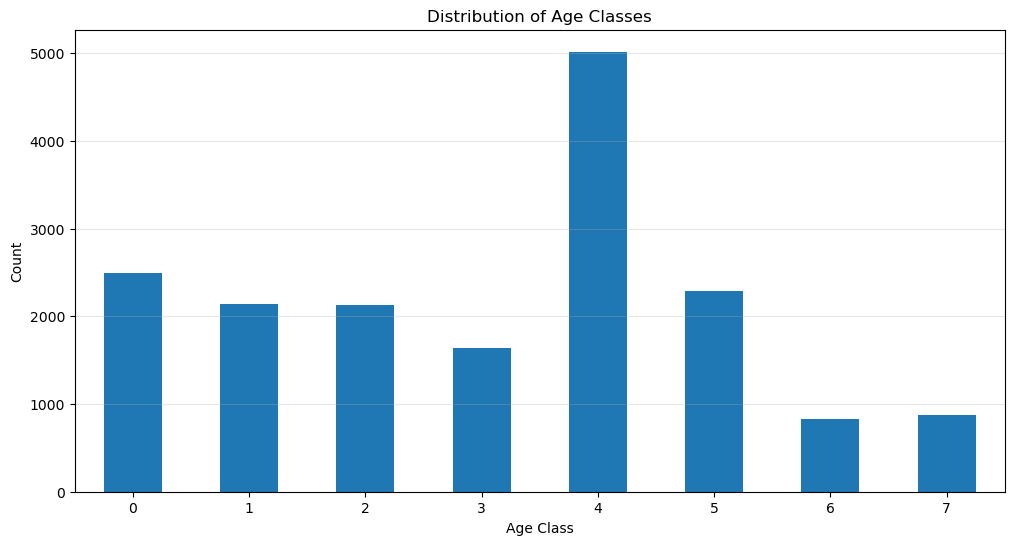

In [38]:
if len(data) > 0:
    print("\nSample data:")
    display(data)
    
    # Show age distribution
    plt.figure(figsize=(12, 6))
    data['age_class'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Age Classes')
    plt.xlabel('Age Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

### Extract faces

In [39]:
creator.extract_faces_archive()

data\faces already exists. Skipping extraction.


### Generate dataset

In [40]:
creator.create_yolo_dataset(train_folds=[0, 1, 2, 3], val_fold=4, output_dir="data/age_dataset_tune")

✅ data/age_dataset_tune already complete. Skipping...


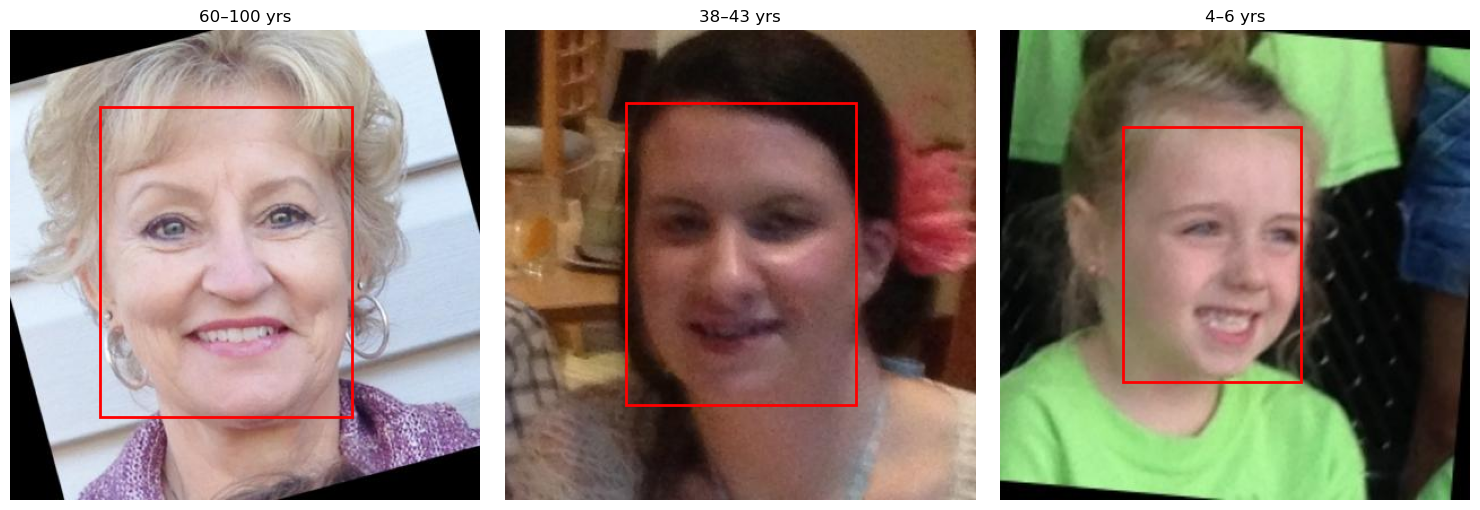

In [41]:
show_random_samples_with_bbox(image_dir="data/age_dataset_tune/images/val",label_dir="data/age_dataset_tune/labels/val",creator=creator,n=3)

## Hyperparameter tuning

### Tune

In [ ]:
if DOWNLOAD_OPTUNA_DB:
    db_path = f'{STORAGE}.db'
    if not os.path.exists(db_path):
        url = 'https://drive.google.com/uc?id=1dCQQHsswZilthnxTc1_kbQ8RvRYctXCs'
        gdown.download(url, db_path, quiet=False)
    else:
        print(f"File '{db_path}' already exists. Skipping download.")

In [ ]:
if RUN_OPTUNA:
    run_optuna_tuning_multi(
        base_dataset_dir='data/age_dataset_tune',
        model_sizes=MODEL_SIZES,
        model_versions=MODEL_VERSIONS, 
        imgsz=IMAGE_SIZE,
        n_trials=10 if not SPEEDRUN else 1, # TEMPDEV
        epochs_per_trial=30 if not SPEEDRUN else 1, # TEMPDEV
        device='0',
        output_base='runs/age_exp'
    )
else:
    print("Config RUN_OPTUNA is False")

## Train

### Generate training dataset 

With different foldsplit than used in tuning

In [ ]:
creator.create_yolo_dataset(train_folds=[0, 1, 2, 4], val_fold=3, output_dir="data/age_dataset_test")

In [ ]:
default_train_params = {
    'imgsz': 416,
    'optimizer': 'AdamW',
    'val': False,
    'deterministic': False,
    'batch': 32 if not SPEEDRUN or not USE_MAX_BATCH else 0.9, # TEMPDEV
    'workers': 3, # TODO: TEMPDEV
    'fraction': 1.0 if not SPEEDRUN else 0.1 # TEMPDEV
}

### Model Sizes

In [ ]:
if RUN_EXP_MODEL_SIZES:
    for size in MODEL_SIZES:
        run_multiple_trainings(
            data_yaml='data/age_dataset_test/data.yaml',
            extra_train_params=default_train_params,
            model_v='8',
            model_size=size,
            db_path=f'sqlite:///{STORAGE}.db',
            study_name='3 model size n', # For best params
            num_runs=5 if not SPEEDRUN else 2, # TEMPDEV
            epochs=30 if not SPEEDRUN else 2, # TEMPDEV
            device='0',
            project='runs/multi_runs',
            conf_threshold=0.25
        )
else:
    print("Config RUN_EXP_MODEL_SIZES is False")

### Data Augmentation

In [ ]:
if RUN_EXP_DATA_AUGMENTATION:
    augmentation_combinations = [
        {
            'hsv_h': 0.015,
            'hsv_s': 0.2,
            'hsv_v': 0.2, 
            'degrees': 20.0,
            'translate': 0.01,
            'scale': 0.2,
            'fliplr': 0.2,
            'mosaic': 0.2
        },
        {
            'hsv_h': 0.02,
            'hsv_s': 0.7,
            'hsv_v': 0.5, 
            'degrees': 35.0,
            'translate': 0.08,
            'scale': 0.4,
            'fliplr': 0.5,
            'mosaic': 0.4
        },
        {
            'hsv_h': 0.03,
            'hsv_s': 0.9,
            'hsv_v': 0.7, 
            'degrees': 50.0,
            'translate': 0.15,
            'scale': 0.6,
            'fliplr': 0.5,
            'mosaic': 0.6
        }
    ]

    for i, combo in enumerate(augmentation_combinations, start=1):
        for close_mosaic_val in [10, 30]:
            experiment_params = {
                **default_train_params,
                **combo,
                'close_mosaic': close_mosaic_val
            }

            print(f"\n=== Running augmentation combo {i} with close_mosaic={close_mosaic_val} ===")

            run_multiple_trainings(
                data_yaml='data/age_dataset_test/data.yaml',
                extra_train_params=experiment_params,
                model_v='8',
                model_size='s',
                db_path=f'sqlite:///{STORAGE}.db',
                study_name='3 model size n', # For best params
                num_runs=5 if not SPEEDRUN else 2, # TEMPDEV
                epochs=30 if not SPEEDRUN else 2, # TEMPDEV
                device='0',
                project='runs/multi_runs',
                conf_threshold=0.25
            )
else:
    print("Config RUN_EXP_DATA_AUGMENTATION is False")

### Model Versions

In [ ]:
if RUN_EXP_MODEL_VERSIONS:
    for version in MODEL_VERSIONS:
        run_multiple_trainings(
            data_yaml='data/age_dataset_test/data.yaml',
            extra_train_params=default_train_params,
            model_v=version,
            model_size='s',
            db_path=f'sqlite:///{STORAGE}.db',
            study_name='3 model size n', # For best params
            num_runs=5 if not SPEEDRUN else 2, # TEMPDEV
            epochs=30 if not SPEEDRUN else 2, # TEMPDEV
            device='0',
            project='runs/multi_runs',
            conf_threshold=0.25
        )
else:
    print("Config RUN_EXP_MODEL_VERSIONS is False")